In [91]:
# clear warnings
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import umap
from sklearn.metrics import silhouette_score
from collections import Counter
import scipy.cluster.hierarchy as hier
from sklearn.cluster import AgglomerativeClustering


#PCA
from sklearn.decomposition import PCA



pd.set_option("display.max_rows", None)

In [2]:
df = pd.read_csv("turkiye-student-evaluation_generic.csv")

In [3]:
df.head()

,instr,class,nb.repeat,attendance,difficulty,Q1,Q2,Q3,Q4,Q5,...,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,Q28
0,1,2,1,0,4,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
1,1,2,1,1,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
2,1,2,1,2,4,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
3,1,2,1,1,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
4,1,2,1,0,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [4]:
# prepare the data
# 1 use all the data - df 
# 2 use only the questionnaire

df_q = df.iloc[:,5::]



# All Data

## PCA

I started with PCA in order to see the similarities of the data. I used every feature for the pca, even our target variables which are repeat and Q10. 

Should we focus on feature selection, i am not sure about that?

Also I used the data that I applied PCA on; and I didn't apply any kind of scaling of the data. Since all the values are in 0-5, except class is 1-13, which I don't think will be an issue for the clustering. The  distances are not too far.


In [5]:
# pca is just to visualize
pca = PCA(n_components = 2, random_state = 42) 
df_pca = pca.fit_transform(df)

In [6]:
# explained variance ratio
variance = np.round(pca.explained_variance_ratio_ * 100, 2)
print(f"Variance loads of each factor are : {variance}")
print(f"Total variance explained {df_pca.cumsum()}%")

Variance loads of each factor are : [58.81 21.2 ]
Total variance explained [ 8.47465089e-01  6.15864931e+00  6.97713004e+00 ... -6.45527280e+00
  5.33485487e+00 -9.44311296e-12]%


In [7]:
df_pca

array([[ 0.84746509,  5.31118422],
       [ 0.81848074,  5.29787132],
       [-9.80821668,  4.96401747],
       ...,
       [-9.31806047, -6.01419844],
       [11.79012767, -5.33485487],
       [11.79012767, -5.33485487]])

didn't look for the optimal components, might be around 5 according to eigenvalues. but I will stick with the 2 

# Kmeans

In [8]:

# elbow method for neighbors
neighbors = pd.DataFrame(columns=['clusters','intertia','silhouette_score'])
for i in range(2,10):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(df_pca)
    score_silhouette = silhouette_score(df_pca, kmeans.labels_, metric='euclidean') 
    neighbors.loc[i] = pd.Series({'clusters':i,
                              'intertia': kmeans.inertia_,
                              'silhouette_score':score_silhouette })


Text(0.5, 0, 'Silhouette Scores of Clusters')

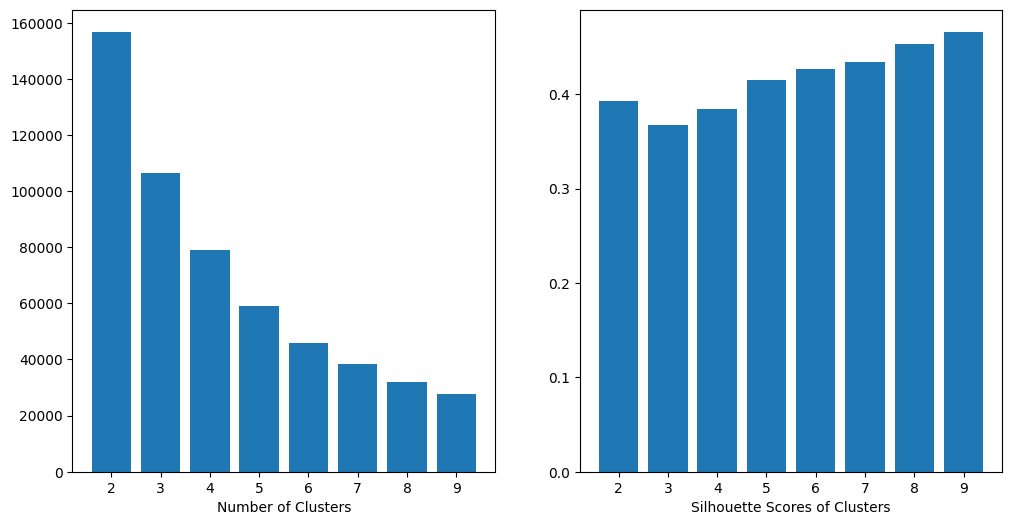

In [9]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(12,6), sharex=True)
ax0.bar(x = 'clusters', height= 'intertia', data=neighbors)
ax0.set_xlabel('Number of Clusters')
ax1.bar(x='clusters',height='silhouette_score', data=neighbors)
ax1.set_xlabel('Silhouette Scores of Clusters')
# 3 clusters to go

In [10]:
kmeans = KMeans(n_clusters= 3, init='k-means++', random_state=42)

model = kmeans.fit(df_pca)
kmeans_labels = kmeans.predict(df_pca)

Counter(kmeans_labels)

Counter({2: 2341, 0: 2243, 1: 1236})

In [11]:
df["kmeans"] = kmeans_labels

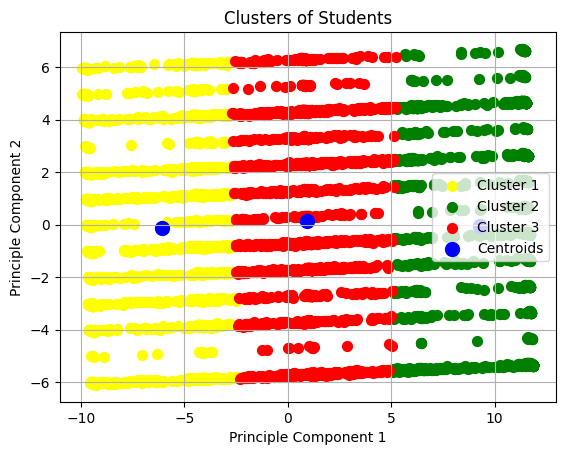

In [12]:
plt.scatter(df_pca[kmeans_labels == 0, 0], df_pca[kmeans_labels == 0, 1], s = 50, c = 'yellow', label = 'Cluster 1')
plt.scatter(df_pca[kmeans_labels == 1, 0], df_pca[kmeans_labels == 1, 1], s = 50, c = 'green', label = 'Cluster 2')
plt.scatter(df_pca[kmeans_labels == 2, 0], df_pca[kmeans_labels == 2, 1], s = 50, c = 'red', label = 'Cluster 3')
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], s = 100, c = 'blue', label = 'Centroids')
plt.title('Clusters of Students')
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.legend()
plt.grid()
plt.show()


# DBSCAN

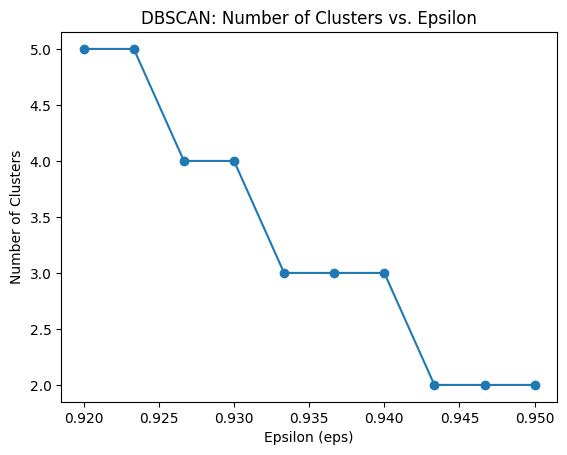

In [13]:
epsilon_values = np.linspace(0.92, 0.95, 10) 
# started with 0.1 to 1, tried various numbers and numbers close to 2 is good 

num_clusters_list = []


for eps in epsilon_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    dbscan_labels = dbscan.fit_predict(df_pca)
    num_clusters = len(np.unique(dbscan_labels)) - 1  # Subtract 1 to account for the noise points (label = -1)
    num_clusters_list.append(num_clusters)

# Plot the number of clusters against epsilon values
plt.plot(epsilon_values, num_clusters_list, marker='o')
plt.xlabel('Epsilon (eps)')
plt.ylabel('Number of Clusters')
plt.title('DBSCAN: Number of Clusters vs. Epsilon')
plt.show()

In [14]:
list(zip(epsilon_values,num_clusters_list))

[(0.92, 5),
 (0.9233333333333333, 5),
 (0.9266666666666666, 4),
 (0.93, 4),
 (0.9333333333333333, 3),
 (0.9366666666666666, 3),
 (0.94, 3),
 (0.9433333333333334, 2),
 (0.9466666666666667, 2),
 (0.95, 2)]

In [15]:
dbscan = DBSCAN(eps=0.93, min_samples=5)
dbscan_labels = dbscan.fit_predict(df_pca)


In [16]:
df["dbscan"] =  dbscan_labels

df["dbscan"].value_counts()

dbscan
 0    5765
 1      26
-1      18
 2       6
 3       5
Name: count, dtype: int64

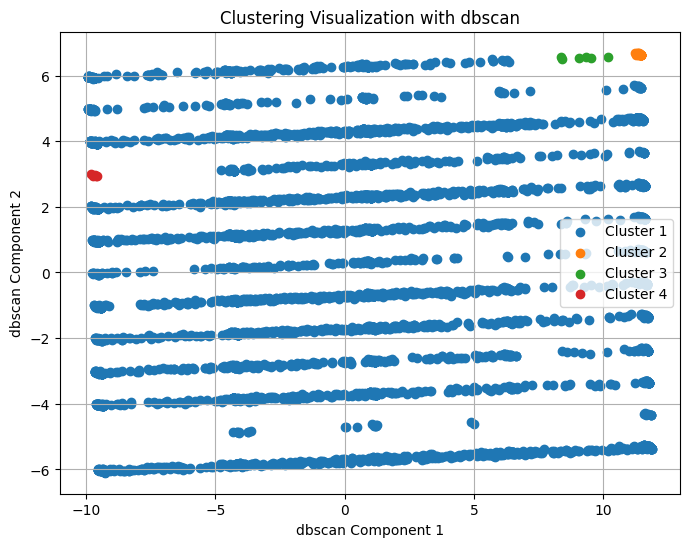

In [17]:
plt.figure(figsize=(8, 6))
for cluster_id in range(df["dbscan"].nunique()-1):
    cluster_data = df_pca[df['dbscan'] == cluster_id]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster_id+1}')
plt.xlabel('dbscan Component 1')
plt.ylabel('dbscan Component 2')
plt.title('Clustering Visualization with dbscan')
plt.legend()
plt.grid()
plt.show()

In [19]:
n_clusters_ = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise_ = list(dbscan_labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 4
Estimated number of noise points: 18


# t-SNE

In [20]:
# Perform t-SNE to reduce dimensionality to 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_data = tsne.fit_transform(df_pca)


kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(df_pca)


df['t-sne'] = cluster_labels


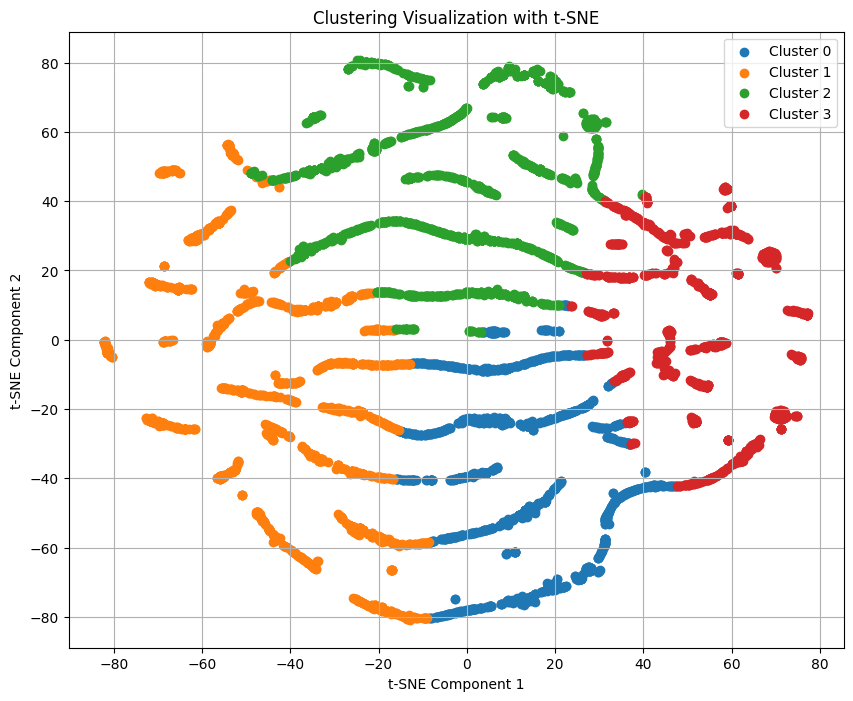

In [21]:
plt.figure(figsize=(10, 8))
for cluster_id in range(4):
    cluster_data = tsne_data[df['t-sne'] == cluster_id]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster_id}')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Clustering Visualization with t-SNE')
plt.legend()
plt.grid()
plt.show()

In [22]:
cluster_whole = df.copy()

# Questionnaire Data

This section will include  the same steps but only for the questionnaire data with the same exact order

In [23]:
df_q.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,Q27,Q28
0,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
1,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
2,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
3,3,3,3,3,3,3,3,3,3,3,...,3,3,3,3,3,3,3,3,3,3
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


## PCA

In [24]:
q_pca = pca.fit_transform(df_q)

In [31]:
# explained variance ratio
variance = np.round(pca.explained_variance_ratio_ * 100, 2)
print(f"Variance loads of each factor are : {variance}")
print(f"Total variance explained {pca.explained_variance_ratio_.cumsum()[1]}%")

Variance loads of each factor are : [82.2   4.52]
Total variance explained 0.8671381678890877%


## KMeans

In [36]:
# elbow method for neighbors
neighbors = pd.DataFrame(columns=['clusters','intertia','silhouette_score'])
for i in range(2,10):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(q_pca)
    score_silhouette = silhouette_score(q_pca, kmeans.labels_, metric='euclidean') 
    neighbors.loc[i] = pd.Series({'clusters':i,
                              'intertia': kmeans.inertia_,
                              'silhouette_score':score_silhouette })

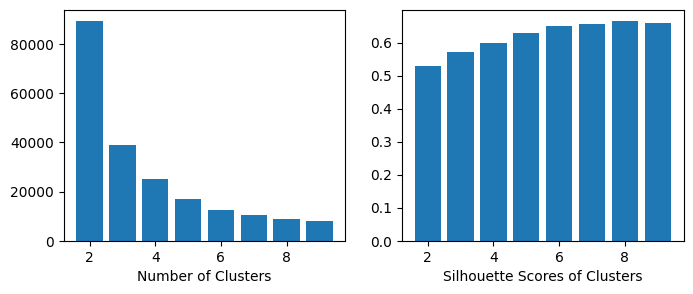

In [40]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(8,3), sharex=True)
ax0.bar(x = 'clusters', height= 'intertia', data=neighbors)
ax0.set_xlabel('Number of Clusters')
ax1.bar(x='clusters',height='silhouette_score', data=neighbors)
_ = ax1.set_xlabel('Silhouette Scores of Clusters')

In [48]:
kmeans = KMeans(n_clusters= 3, init='k-means++', random_state=42)

model = kmeans.fit(q_pca)
kmeans_labels = kmeans.predict(q_pca)

Counter(kmeans_labels)

Counter({0: 2358, 2: 2222, 1: 1240})

In [57]:
df_q["kmeans"] = kmeans_labels

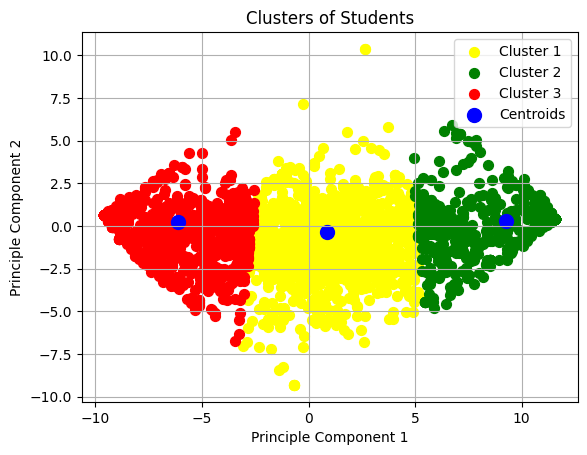

In [49]:
plt.scatter(q_pca[kmeans_labels == 0, 0], q_pca[kmeans_labels == 0, 1], s = 50, c = 'yellow', label = 'Cluster 1')
plt.scatter(q_pca[kmeans_labels == 1, 0], q_pca[kmeans_labels == 1, 1], s = 50, c = 'green', label = 'Cluster 2')
plt.scatter(q_pca[kmeans_labels == 2, 0], q_pca[kmeans_labels == 2, 1], s = 50, c = 'red', label = 'Cluster 3')
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], s = 100, c = 'blue', label = 'Centroids')
plt.title('Clusters of Students')
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.legend()
plt.grid()
plt.show()


## DBSCAN

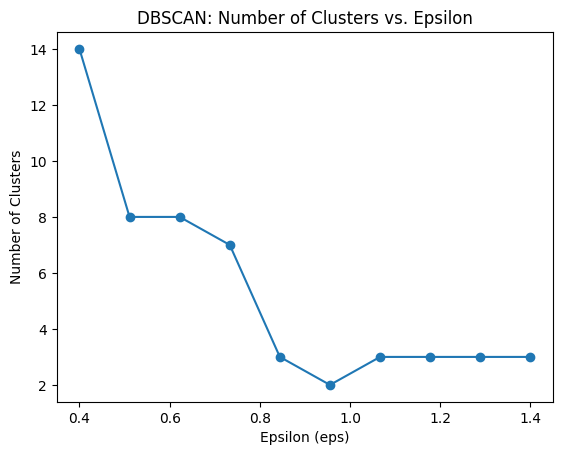

In [80]:
epsilon_values = np.linspace(0.4,1.4, 10) 
# started with 0.1 to 1, tried various numbers and numbers close to 2 is good 

results = {}


for eps in epsilon_values:
    dbscan = DBSCAN(eps=eps, min_samples=5)
    dbscan_labels = dbscan.fit_predict(q_pca)
    n_noise_ = list(dbscan_labels).count(-1)
    num_clusters = len(np.unique(dbscan_labels)) - 1  # Subtract 1 to account for the noise points (label = -1)
    results[eps] = {"clusters" : num_clusters,
                   "noise": n_noise_}

# Plot the number of clusters against epsilon values
plt.plot(epsilon_values, num_clusters_list, marker='o')
plt.xlabel('Epsilon (eps)')
plt.ylabel('Number of Clusters')
plt.title('DBSCAN: Number of Clusters vs. Epsilon')
plt.show()

In [81]:
results

{0.4: {'clusters': 14, 'noise': 186},
 0.5111111111111111: {'clusters': 8, 'noise': 97},
 0.6222222222222222: {'clusters': 2, 'noise': 63},
 0.7333333333333334: {'clusters': 3, 'noise': 39},
 0.8444444444444444: {'clusters': 3, 'noise': 24},
 0.9555555555555556: {'clusters': 2, 'noise': 15},
 1.0666666666666667: {'clusters': 2, 'noise': 14},
 1.1777777777777776: {'clusters': 3, 'noise': 7},
 1.2888888888888888: {'clusters': 2, 'noise': 6},
 1.4: {'clusters': 1, 'noise': 6}}

In [86]:
dbscan = DBSCAN(eps=0.84, min_samples=5)
dbscan_labels = dbscan.fit_predict(q_pca)


In [87]:
n_clusters_ = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise_ = list(dbscan_labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 3
Estimated number of noise points: 24


In [88]:
df_q["dbscan"] = dbscan_labels

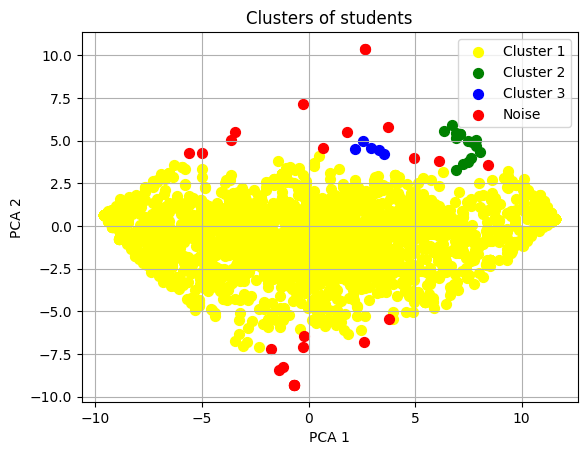

In [106]:
plt.scatter(q_pca[dbscan_labels == 0, 0], q_pca[dbscan_labels == 0, 1], s = 50, c = 'yellow', label = 'Cluster 1')
plt.scatter(q_pca[dbscan_labels == 1, 0], q_pca[dbscan_labels == 1, 1], s = 50, c = 'green', label = 'Cluster 2')
plt.scatter(q_pca[dbscan_labels == 2, 0], q_pca[dbscan_labels == 2, 1], s = 50, c = 'blue', label = 'Cluster 3')
#plt.scatter(X_pca[y == 3, 0], X_pca[y == 3, 1], s = 50, c = 'black', label = 'Cluster 4')
plt.scatter(q_pca[dbscan_labels == -1, 0], q_pca[dbscan_labels == -1, 1], s = 50, c = 'red', label = 'Noise')
plt.title('Clusters of students')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.grid()
plt.show()


## t-SNE

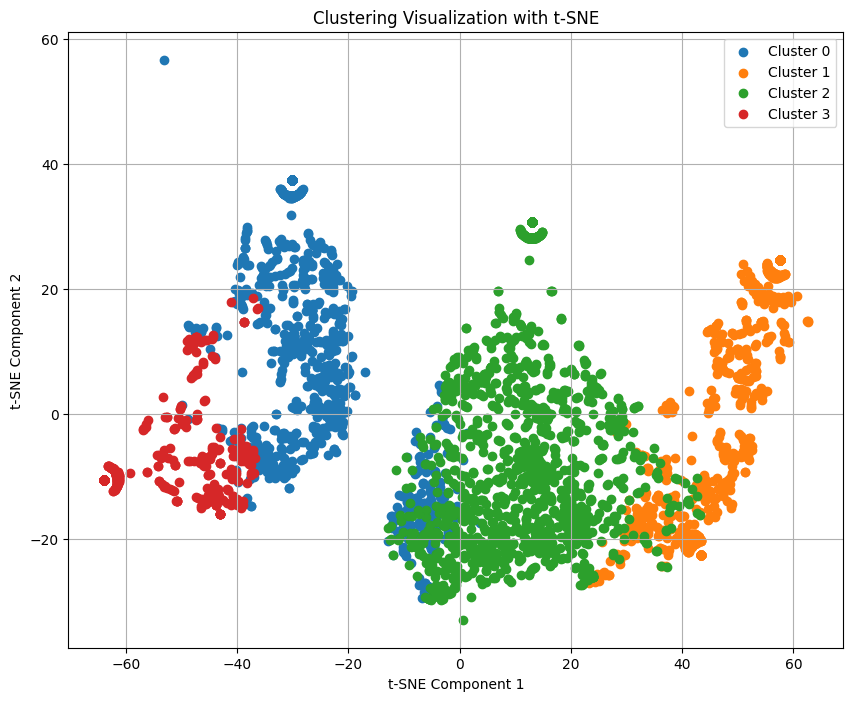

In [90]:
# Perform t-SNE to reduce dimensionality to 2D for visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_data = tsne.fit_transform(df_q)


kmeans = KMeans(n_clusters=4, random_state=42)
cluster_labels = kmeans.fit_predict(df_q)


df_q['t-sne'] = cluster_labels

plt.figure(figsize=(10, 8))
for cluster_id in range(4):
    cluster_data = tsne_data[df_q['t-sne'] == cluster_id]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], label=f'Cluster {cluster_id}')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('Clustering Visualization with t-SNE')
plt.legend()
plt.grid()
plt.show()

## Agglomerative Clustering

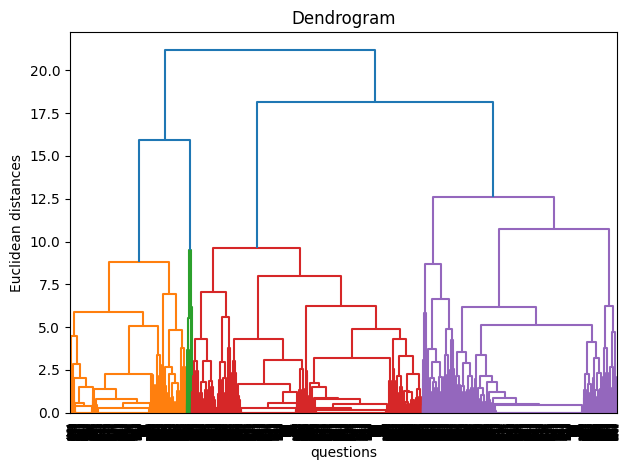

In [103]:
dendrogram = hier.dendrogram(hier.linkage(q_pca,
                                          method = 'complete')) #ward method returns 2 also
plt.title('Dendrogram')
plt.xlabel('questions')
plt.ylabel('Euclidean distances')
plt.tight_layout()
plt.show()


In [100]:
model = AgglomerativeClustering(n_clusters = 2, 
                          affinity ='euclidean', 
                          linkage ='ward')
agg_clusters = model.fit_predict(q_pca)

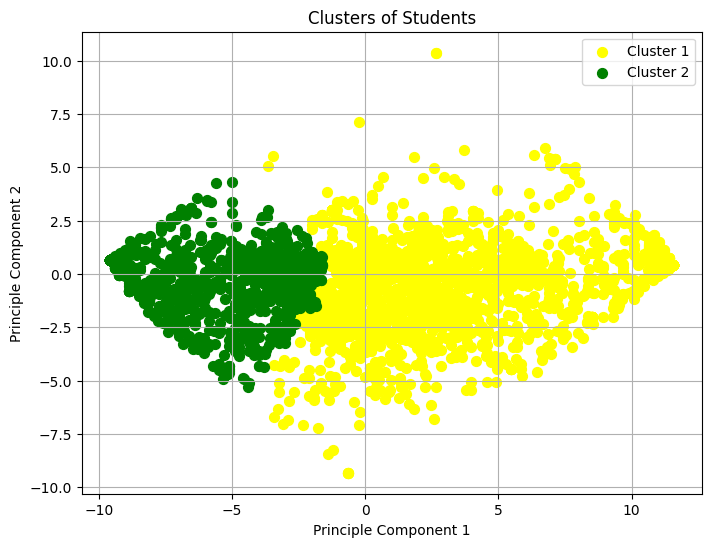

In [102]:
plt.figure(figsize= (8,6))
plt.scatter(q_pca[agg_clusters == 0, 0], q_pca[agg_clusters == 0, 1], s = 50, c = 'yellow', label = 'Cluster 1')
plt.scatter(q_pca[agg_clusters == 1, 0], q_pca[agg_clusters == 1, 1], s = 50, c = 'green', label = 'Cluster 2')
#plt.scatter(q_pca[kmeans_labels == 2, 0], q_pca[kmeans_labels == 2, 1], s = 50, c = 'red', label = 'Cluster 3')
#plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], s = 100, c = 'blue', label = 'Centroids')
plt.title('Clusters of Students')
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.legend()
plt.grid()
plt.show()


## Kmeans